<a href="https://colab.research.google.com/github/niyathnair/AutoEval_VL2G/blob/main/Copy_of_Final(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [2]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [3]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
base_path = "data"
words_list = []

with open(f"{base_path}/words.txt", "r") as file:
    for line in file.readlines():
        if line[0] == "#":
            continue
        if line.split(" ")[1] != "err":
            words_list.append(line.strip())

print(len(words_list))
np.random.shuffle(words_list)

96456


In [5]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]
val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [6]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for i, file_line in enumerate(samples):
        line_split = file_line.strip().split(" ")
        # Extracting image name and parts
        image_name = line_split[0]
        part1 = image_name.split("-")[0]
        part2 = image_name.split("-")[1]
        img_path = os.path.join(base_image_path, part1, part1+"-"+part2,image_name+".png")
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])  # Assuming image name as label
    return paths, corrected_samples

In [7]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [8]:
!pip freeze > requirements.txt


In [9]:
import sys

print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)



Python version
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Version info.
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [10]:
train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [11]:
train_labels_cleaned = []
characters = set()
max_len = 0

# Clean and process each label
for label in train_labels:
    label = label.split(" ")[-1].strip()  # Extract the last part of the label and remove leading/trailing whitespaces
    for char in label:
        characters.add(char)  # Add each character to the set of characters
    max_len = max(max_len, len(label))  # Update max_len if the current label is longer
    train_labels_cleaned.append(label)  # Append the cleaned label to the list

# Output some statistics
print("Maximum length:", max_len)
print("Vocabulary size:", len(characters))

# Check some label samples
print("Some label samples:", train_labels_cleaned[:10])

Maximum length: 21
Vocabulary size: 78
Some label samples: ['sure', 'he', 'during', 'of', 'booty', 'gastronomy', 'boy', 'The', 'and', 'in']


In [12]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()  # Extract the last part of the label and remove leading/trailing whitespaces
        cleaned_labels.append(label)  # Append the cleaned label to the list
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [13]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    mask_token=None,
    invert=True
)

In [14]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do the same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0]  # No padding along the channel dimension
        ]
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)

    return image

In [15]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)  # Read image from file
    image = tf.image.decode_png(image, channels=1)  # Decode PNG image (assuming grayscale)
    image = distortion_free_resize(image, img_size)  # Resize the image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [16]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned, batch_size)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned, batch_size)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned, batch_size)

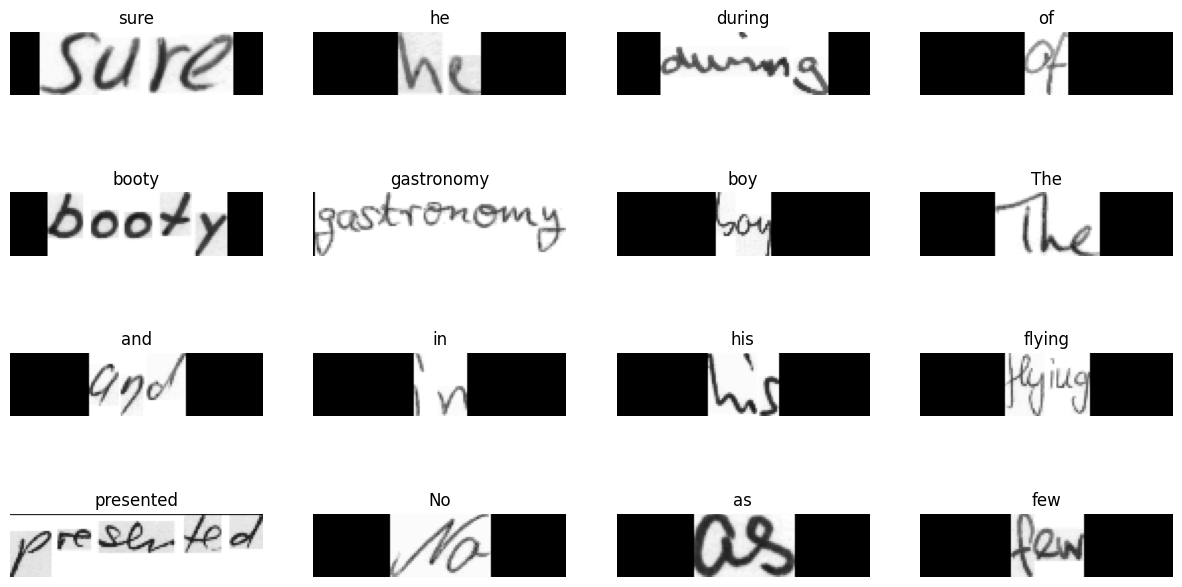

In [17]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

_, ax = plt.subplots(4, 4, figsize=(15, 8))
for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

plt.show()

In [18]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 14.6 MB/s eta 0:00:00


In [19]:
from tensorflow import keras

In [20]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model(image_width=64, image_height=64):
    # Define inputs
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # Convolutional layers
    x = keras.layers.Conv2D(32,
                            (3, 3),
                            activation="relu",
                            padding="same",
                            kernel_initializer='he_normal',  # Adding He normal initializer
                            name="Conv1")(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = keras.layers.Conv2D(64,
                            (3, 3),
                            activation="relu",
                            padding="same",
                            kernel_initializer='he_normal',  # Adding He normal initializer
                            name="Conv2")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Reshape layer
    x = keras.layers.Reshape((32, 512))(x)

    # Dense layer
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    # Bidirectional LSTM layers
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), name="bidirectional_4")(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True), name="bidirectional_5")(x)

    # Output layer
    output = keras.layers.Dense(81, activation="softmax", name="dense2")(x)

    # Pass through CTCLayer
    output = CTCLayer(name="ctc_loss")(labels, output)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")

    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

# Build the model
model = build_model()

# Display model summary
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 32, 32, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 32, 32, 64)           18496     ['pool1[0][0]']               
                                                                             

In [21]:
print(labels.shape)

(64, 21)


In [22]:
validation_images=[]
validation_labels=[]

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])

In [23]:
new_validation_images = []
for image in validation_images:
    resized_image = tf.image.resize(image, (64, 64))
    new_validation_images.append(resized_image)

validation_images = new_validation_images

In [24]:
def calculate_edit_distance(labels, predictions):
    # Convert labels to sparse
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse
    input_len = tf.cast(np.ones(predictions.shape[0]) * predictions.shape[1], dtype=tf.int32)
    predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :tf.reduce_max(input_len)]
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # Compute individual edit distances and average
    edit_distances = tf.edit_distance(sparse_predictions, sparse_labels, normalize=False)
    average_edit_distance = tf.reduce_mean(edit_distances)

    return average_edit_distance

In [25]:
class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
        print(f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")

In [26]:
# epochs = 28  # To get good results this should be at least 50.
# model = build_model()
# prediction_model = keras.models.Model(
#     model.get_layer(name="image").input, model.get_layer(name="dense2").output
# )
# edit_distance_callback = EditDistanceCallback(prediction_model)

epochs = 15 # To get good results this should be at least 50.
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

In [27]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    # steps_per_epoch=5  # Set the number of steps per epoch to 5
)

Epoch 1/10
1/1 [==============================] - 1s 1s/step
Mean edit distance for epoch 1: 31.5163
1357/1357 [==============================] - 158s 100ms/step - loss: 13.5752 - val_loss: 11.9993
Epoch 2/10
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 2: 31.5439
1357/1357 [==============================] - 75s 55ms/step - loss: 10.7530 - val_loss: 9.5916
Epoch 3/10
1/1 [==============================] - 0s 21ms/step
Mean edit distance for epoch 3: 31.6476
1357/1357 [==============================] - 74s 55ms/step - loss: 8.6488 - val_loss: 7.6635
Epoch 4/10
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 4: 31.7021
1357/1357 [==============================] - 75s 55ms/step - loss: 6.5809 - val_loss: 5.6384
Epoch 5/10
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 5: 31.6298
1357/1357 [==============================] - 73s 53ms/step - loss: 5.0665 - val_loss: 4.3714
Epoch 6/10
1/1 [=

2/2 [==============================] - 2s 14ms/step


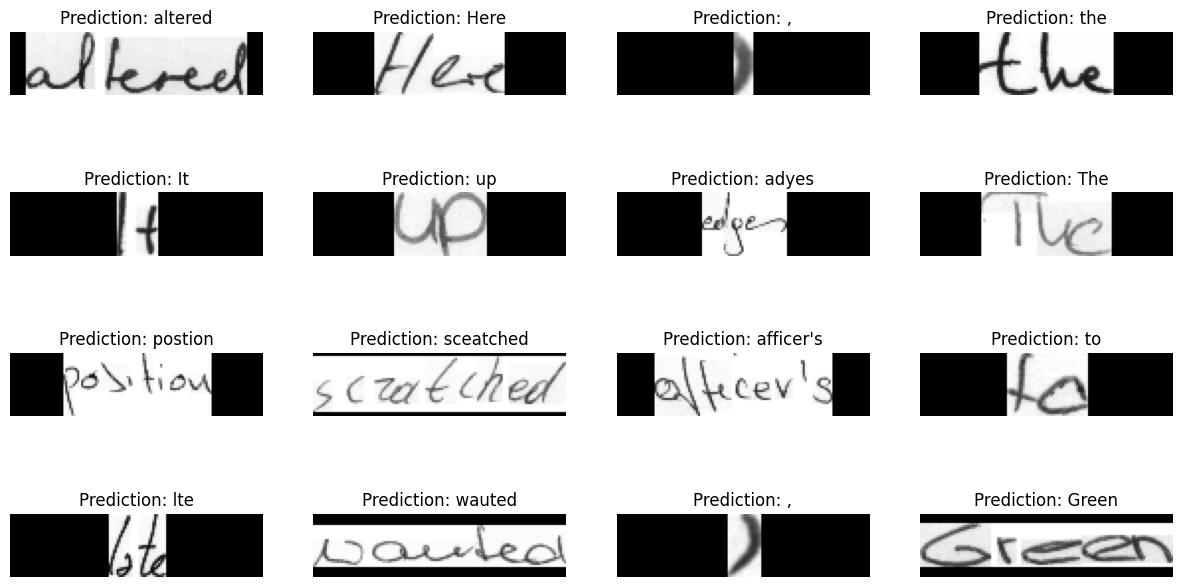

In [28]:
def decode_batch_predictions(pred, num_to_char):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res))
        res = tf.strings.reduce_join(res).numpy().decode("utf-8")  # Convert to UTF-8
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, num_to_char)  # Pass num_to_char
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=(1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')

plt.show()

In [29]:
# additional_epochs = 10
# history = model.fit(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=additional_epochs,
#     callbacks=[edit_distance_callback],
#     # steps_per_epoch=5  # Set the number of steps per epoch to 5
# )

2/2 [==============================] - 0s 10ms/step


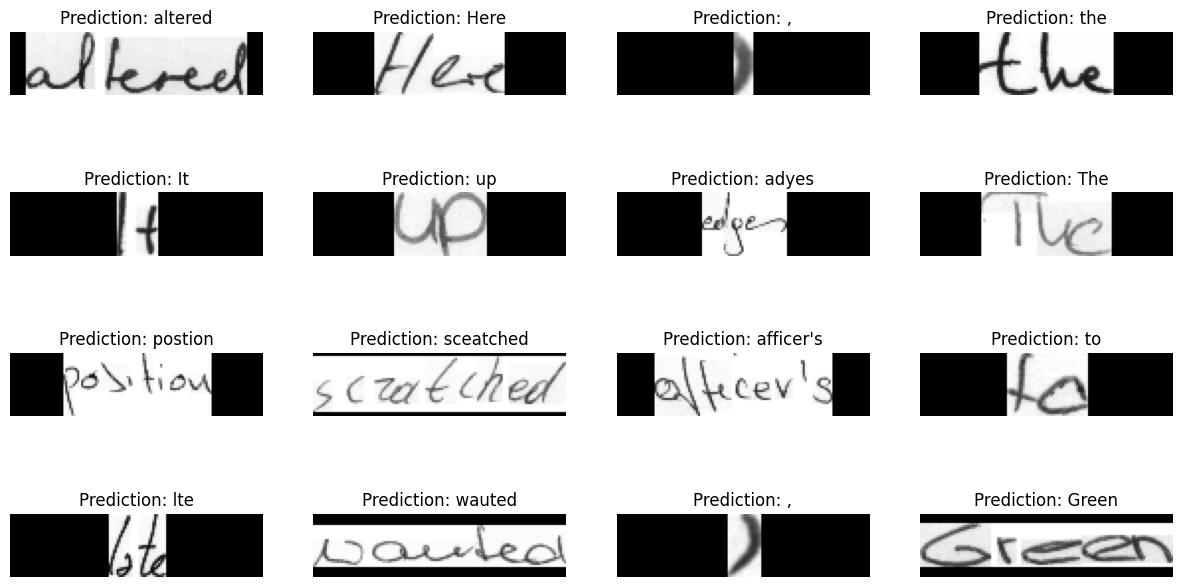

In [30]:
def decode_batch_predictions(pred, num_to_char):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res))
        res = tf.strings.reduce_join(res).numpy().decode("utf-8")  # Convert to UTF-8
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, num_to_char)  # Pass num_to_char
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=(1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')

plt.show()

In [31]:
# additional_epochs = 5
# history = model.fit(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=additional_epochs,
#     callbacks=[edit_distance_callback],
#     # steps_per_epoch=5  # Set the number of steps per epoch to 5
# )

2/2 [==============================] - 0s 11ms/step


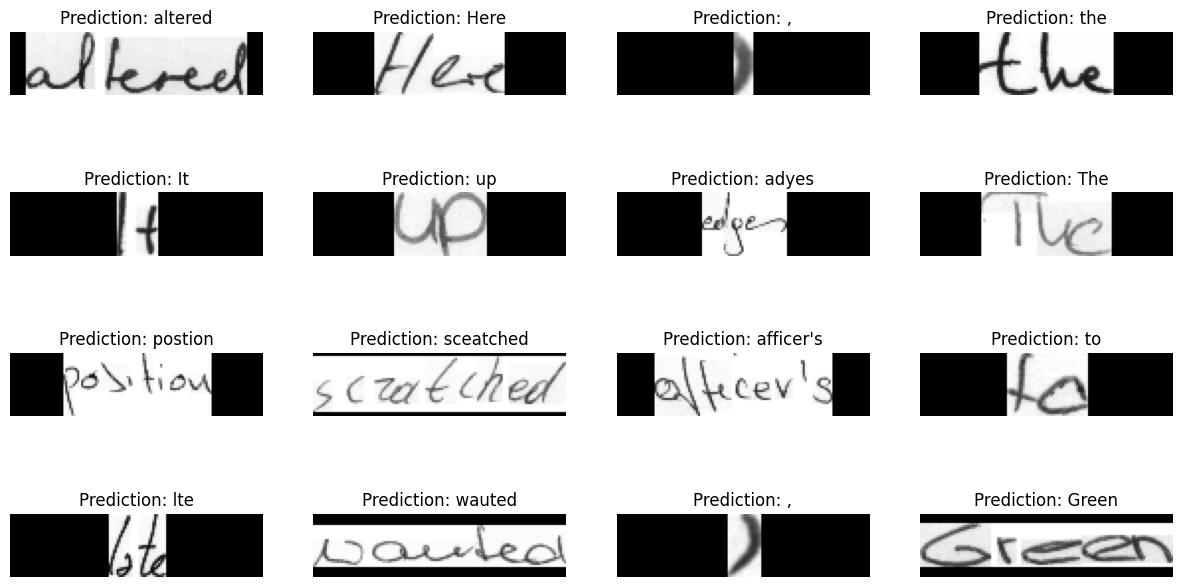

In [32]:
def decode_batch_predictions(pred, num_to_char):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res))
        res = tf.strings.reduce_join(res).numpy().decode("utf-8")  # Convert to UTF-8
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, num_to_char)  # Pass num_to_char
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=(1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')

plt.show()

In [33]:
# additional_epochs = 5
# history = model.fit(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=additional_epochs,
#     callbacks=[edit_distance_callback],
#     # steps_per_epoch=5  # Set the number of steps per epoch to 5
# )

2/2 [==============================] - 0s 16ms/step


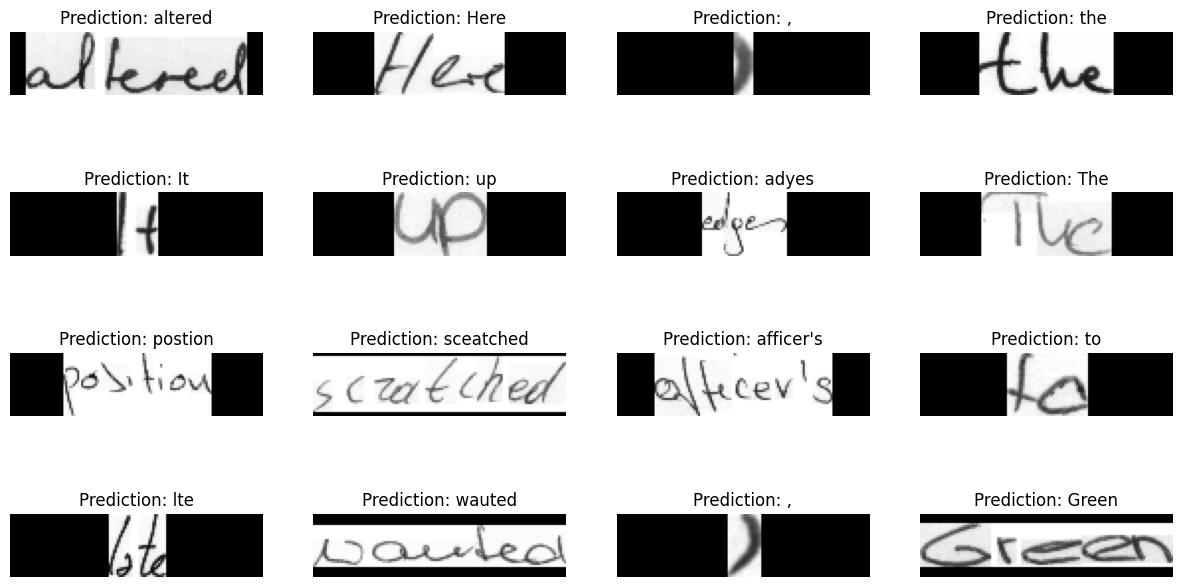

In [34]:
def decode_batch_predictions(pred, num_to_char):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res))
        res = tf.strings.reduce_join(res).numpy().decode("utf-8")  # Convert to UTF-8
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, num_to_char)  # Pass num_to_char
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=(1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')

plt.show()

In [35]:
model.save('my_trained_model_with_ctc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# from tensorflow.keras.models import load_model

# # Define a dictionary with custom objects
# custom_objects = {'CTCLayer': CTCLayer}

# # Load the model with custom objects
# loaded_model = load_model('my_trained_model_with_ctc.h5', custom_objects=custom_objects)

In [37]:
# import numpy as np

# # Assume test images are stored in a NumPy array of shape (num_samples, image_width, image_height, 1)
# # and test labels are stored in a NumPy array of shape (num_samples, label_length)
# test_images = np.random.rand(10, 64, 64, 1)  # Replace with actual test images
# test_labels = np.random.randint(0, 81, size=(10, 10))  # Replace with actual test labels

# # Create a test dataset
# test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# test_ds = test_ds.batch(1)  # Adjust batch size as needed

In [38]:
# for test_image, test_label in test_ds.take(5):  # Take the first 5 samples for testing
#     # Prepare the inputs for the model
#     inputs = {"image": test_image, "label": test_label}

#     # Get the predictions
#     predictions = loaded_model.predict(inputs)

#     # Process and print the predictions
#     # You might need to decode the predictions based on your model's output format
#     print(f"True labels: {test_label.numpy()}")
#     print(f"Predicted raw output: {predictions}")

1/1 [==============================] - 2s 2s/step
True labels: [[40 71 12 43 79 36 59  8 62 73]]
Predicted raw output: [[[3.57634053e-06 1.13632741e-04 9.38158855e-03 ... 1.01117366e-04
   2.15103819e-06 7.91751668e-02]
  [1.04204423e-08 4.99089348e-09 3.94253439e-05 ... 2.88973734e-08
   4.55285720e-09 9.97068107e-01]
  [4.98330488e-09 4.20313420e-08 4.17633782e-05 ... 1.15568724e-07
   1.70615999e-09 9.96925890e-01]
  ...
  [4.91886176e-08 2.66579917e-07 6.34748838e-04 ... 3.26118084e-06
   2.06300843e-08 9.55175996e-01]
  [1.50035589e-07 6.14016471e-07 3.03377281e-03 ... 3.51685048e-06
   4.87980500e-08 9.50062037e-01]
  [4.70499981e-06 8.62740417e-05 1.05300859e-01 ... 2.32029888e-05
   2.44528792e-06 1.07703628e-02]]]
1/1 [==============================] - 0s 24ms/step
True labels: [[53 49 31 73 61 11 40 43 49 59]]
Predicted raw output: [[[2.83503459e-06 3.92718212e-05 7.79396761e-03 ... 7.35959911e-05
   1.79030985e-06 3.31370048e-02]
  [7.56667529e-09 4.76332085e-09 1.82027616e-

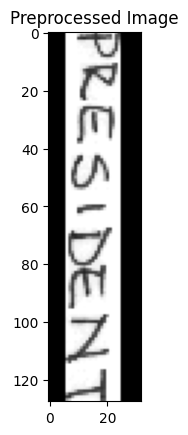

In [39]:
# image_path = "/content/data/words/a04/a04-000/a04-000-00-00.png"
# processed_image = preprocess_image(image_path)

# # Display the preprocessed image
# plt.imshow(tf.squeeze(processed_image), cmap='gray')
# plt.title('Preprocessed Image')
# plt.show()